In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds

In [2]:
ds = tfds.load('cifar10', split='train', as_supervised=True, shuffle_files=True )

In [3]:
def add_noise(img,factor=0.22):  
  img = img + (np.random.randn(*img.shape))*factor
  img = img.clip(0.,1.)
  return img 

In [4]:
x = []
y = []
itr=0
for ex in ds:
  itr+=1
  img,_= ex
  img = img.numpy().astype('float')/255.0
  n_img = add_noise(img)
  x.append(n_img)
  y.append(img)
  # if itr== 5000:
  #   break
    
x = np.array(x)
y = np.array(y)

print('Number of images in dataset:',x.shape[0])
print('Shape of image:',x.shape[1:])


Number of images in dataset: 50000
Shape of image: (32, 32, 3)


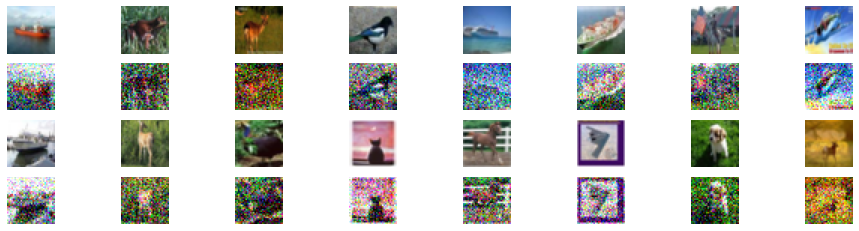

In [5]:
# mnist images
rows = 2
cols = 8
seed = np.random.randint(1,500)
subplot_size = 2
f = plt.figure(figsize=(subplot_size*cols ,subplot_size*rows))
for i in range(rows):
  for j in range(cols):
    f.add_subplot(rows*2,cols, (2*i*cols)+(j+1))
    plt.imshow(y[seed+(i*cols+j)])
    plt.axis('off')
  for j in range(cols):
    f.add_subplot(rows*2,cols, ((2*i+1)*cols)+(j+1))
    plt.imshow(x[seed+(i*cols+j)])
    plt.axis('off')
plt.savefig('cifar10_orig.png')

In [6]:
split_size = int(0.8 * (x.shape[0]))

x_train,y_train = x[:split_size],y[:split_size]
x_valid,y_valid = x[split_size:],y[split_size:]

print('Training dataset shape:',x_train.shape)
print('Validation dataset shape:',x_valid.shape)

Training dataset shape: (40000, 32, 32, 3)
Validation dataset shape: (10000, 32, 32, 3)


In [7]:
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU, Input,Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras import Model

size = 32
channel = 3

# Encoder 
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8,verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=8, verbose=1)
# op = tf.keras.optimizers.Adam(lr=1e-4)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
history = autoencoder.fit(y_train,y_train, validation_data=(y_valid,y_valid), epochs=360, batch_size=256, callbacks=[reduce_lr,early_stopping], verbose=1)

Epoch 1/360
157/157 [==============================] - 4s 24ms/step - loss: 0.5723 - val_loss: 0.6335
Epoch 2/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5584 - val_loss: 0.6112
Epoch 3/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5571 - val_loss: 0.5779
Epoch 4/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5566 - val_loss: 0.5622
Epoch 5/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5562 - val_loss: 0.5534
Epoch 6/360
157/157 [==============================] - 3s 22ms/step - loss: 0.5559 - val_loss: 0.5522
Epoch 7/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5556 - val_loss: 0.5556
Epoch 8/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5555 - val_loss: 0.5632
Epoch 9/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5553 - val_loss: 0.5574
Epoch 10/360
157/157 [==============================] - 3s 21ms/step - loss: 0.555

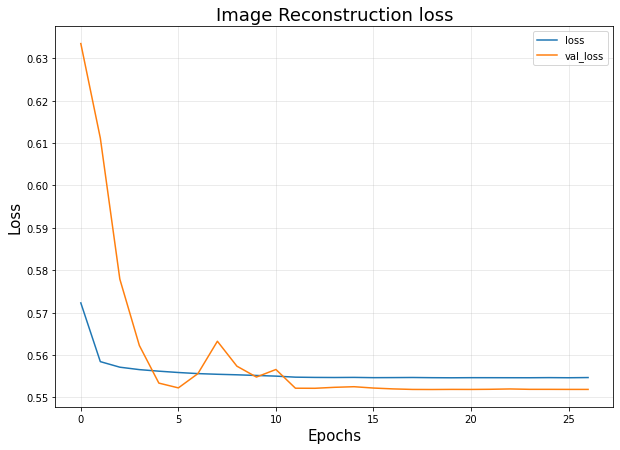

In [10]:
# image reconstruction loss
f = plt.figure(figsize=(10,7))
f.add_subplot()

plt.plot(history.epoch,history.history['loss'],label='loss')
plt.plot(history.epoch,history.history['val_loss'], label='val_loss')
plt.title('Image Reconstruction loss', fontsize=18)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('image_reconstruction_loss.png')
plt.show()

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8,verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=8, verbose=1)
# op = tf.keras.optimizers.Adam(lr=1e-4)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
history = autoencoder.fit(x_train,y_train, validation_data=(x_valid,y_valid), epochs=360, batch_size=256, callbacks=[reduce_lr,early_stopping], verbose=1)

Epoch 1/360
157/157 [==============================] - 4s 23ms/step - loss: 0.5648 - val_loss: 0.5635
Epoch 2/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5636 - val_loss: 0.5643
Epoch 3/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5634 - val_loss: 0.5641
Epoch 4/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5631 - val_loss: 0.5612
Epoch 5/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5631 - val_loss: 0.5621
Epoch 6/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5630 - val_loss: 0.5621
Epoch 7/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5629 - val_loss: 0.5649
Epoch 8/360
157/157 [==============================] - 3s 21ms/step - loss: 0.5629 - val_loss: 0.5637
Epoch 9/360
154/157 [============================>.] - ETA: 0s - loss: 0.5628
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
157/157 [================

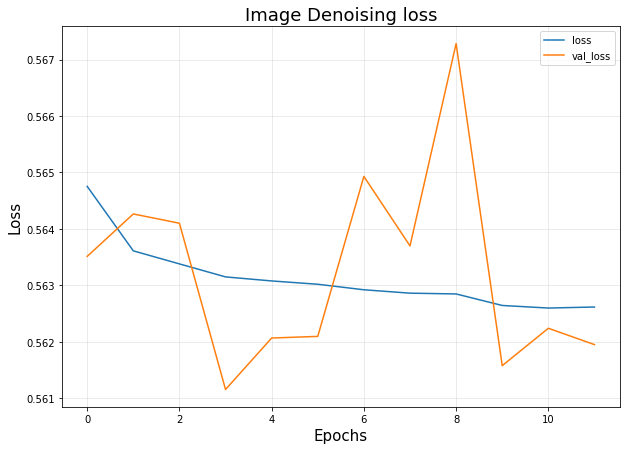

In [14]:
# image denoising loss
f = plt.figure(figsize=(10,7))
f.add_subplot()

plt.plot(history.epoch,history.history['loss'],label='loss')
plt.plot(history.epoch,history.history['val_loss'], label='val_loss')
plt.title('Image Denoising loss', fontsize=18)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('image_denoising_loss.png')
plt.show()

In [15]:
autoencoder.save('CIFAR10_AE_weights.h5')

In [16]:
# Sample few test images
seed = np.random.randint(1,500)
x = x_valid[seed:(seed+8)]
yy = y_valid[seed:(seed+8)]
y_hat = autoencoder.predict(x)

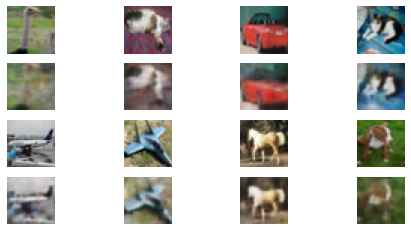

In [17]:
# Cifar10 sample images
rows = 2
cols = 4
subplot_size = 2
f = plt.figure(figsize=(subplot_size*cols ,subplot_size*rows))
for i in range(rows):
  for j in range(cols):
    f.add_subplot(rows*2,cols, (2*i*cols)+(j+1))
    plt.imshow(yy[i*cols+j])
    plt.axis('off')
  for j in range(cols):
    f.add_subplot(rows*2,cols, ((2*i+1)*cols)+(j+1))
    plt.imshow(y_hat[i*cols+j])
    plt.axis('off')
plt.savefig('cifar10_predict.png')